<a href="https://colab.research.google.com/github/K-3-LT/defacto_global_bu/blob/main/Pinecone_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
!pip install python-docx openai transformers pinecone-client

In [ ]:
import docx
import openai
import csv
from pathlib import Path
from transformers import GPT2Tokenizer
from google.colab import files
import pinecone
from tqdm import tqdm

# 1. Data Extraction

## Instructions
1. This part best runs on Jupyter Notebook.
2. Install selenium and bs4.
3. Download the latest version of chrome driver from https://chromedriver.chromium.org/ , make sure the excutable path is /usr/local/bin/
4. Make sure the chrome driver version matches the the user version of Chrome.

We use the scrapped data here.

For the process of scraping, please refer to https://drive.google.com/file/d/10Vqm2Hx1U3uu-ruaZMJNDpbTXTCf4Sdx/view?usp=sharing

# 2. Embedding

In [ ]:
# read word doc
def read_docx(file_path):
  doc = docx.Document(file_path)
  #files.upload()
  text = []
  for paragraph in doc.paragraphs:
    # skip links
    if 'http://' not in paragraph.text and 'https://' not in paragraph.text:
      text.append(paragraph.text)
  return '\n'.join(text)

In [ ]:
content = read_docx('/content/defacto.docx')

# split content into small paragraphs
paragraphs = content.split('\n')

# Input openai api
api_key = input("Please ensure proper inputting of OpenAI API key:")
openai.api_key = api_key

# Tokenize paragraph
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Make sure each section is less than 4096
sections = []
current_section = ""
for paragraph in paragraphs:
  tokens = tokenizer.encode(paragraph, add_special_tokens=False)
  if len(tokens) + len(tokenizer.encode(current_section, add_special_tokens=False)) > 4000:
    current_section += '\n'
    sections.append(current_section)
    current_section = paragraph
  else:
    current_section += f'\n{paragraph}'

if current_section:
  sections.append(current_section)

# transfer paragraph into embedding
def create_embedding(section):
  model_engine = "text-embedding-ada-002"
  openai.api_key = api_key
  response = openai.Embedding.create(
      model=model_engine,
      input=section,
  )
  return response['data'][0]['embedding']

embeddings = [create_embedding(section) for section in tqdm(sections)]

print(embeddings)

In [ ]:
# Pinecone API key
pinecone_api_key = input("Please enter your Pinecone API key: ")
pinecone_environment = input("Please enter your Pinecone Environment: ")

# Pinecone index name
index_name = input("please enter your Pinecone vector database index name(only lower-case characters or number): ")

# Initial Pinecone
pinecone.init(api_key=pinecone_api_key,environment=pinecone_environment)

# Create a new Pinecone index
pinecone.create_index(name = index_name, dimension=len(embeddings[0]),metric='cosine', pod_type='p2')

# Access index instance
index = pinecone.Index(index_name=index_name)

# Create metadata list
metadata = [{"report_context": section} for section in sections]

# upsert vectors and metadata into index
for i, (embedding, meta) in enumerate(zip(embeddings, metadata)):
  index.upsert(vectors=[(str(i), embedding, meta)])

# 3. Query

In [ ]:
query = input("What is your question? ")

xq = openai.Embedding.create(input=query, engine="text-embedding-ada-002")['data'][0]['embedding']

# Find the top 5 match score data
res = index.query([xq], top_k=5, include_metadata=True)

# Calculate match score and feed the best match data into gpt
#for match in res['matches']:
    # Store highest score report context
    #print(f"{match['score']:.2f}: {match['metadata']['report_context']}")

info = res['matches'][0]['metadata']['report_context']

def ask_question(query, info):
    messages = [
        {"role": "system", "content": "You are a helpful customer assistant of deFacto Inc.."},
        {"role": "assistant", "content": info},
        {"role": "user", "content": query},
    ]

    response = openai.ChatCompletion.create(
        model="gpt-4-0613", #gpt-4-0613 / gpt-3.5-turbo-0613
        messages=messages,
    )

    return response['choices'][0]['message']['content']


print(ask_question(query, info))


What is your question? How can Data Locks be configured within an Application, and can they be applied on a model by model basis?
Data Locks in deFacto allow you to control security at a data level, rather than a user level. They are a handy tool to restrict or grant data access based on specific conditions set within dimensions. This can be particularly useful in budget planning schedules when you need to ensure write access is only available during certain periods.

Data Locks configuration works at the model level and can be effectively applied on a model by model basis. Here are the general steps to configure Data Locks:

1. Navigate to the Model you want to set Data Locks for in the dFModeler.
2. On the Tools ribbon, click on the Lock icon to open the Data Locks window.
3. Click the 'New Data Lock' button.
4. In the New Data Lock window, provide a label for the lock, select the Lock Type (Read, Write, or Both), and select the Lock Status (Locked or Unlocked).
5. Next, define the c

# 4. Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


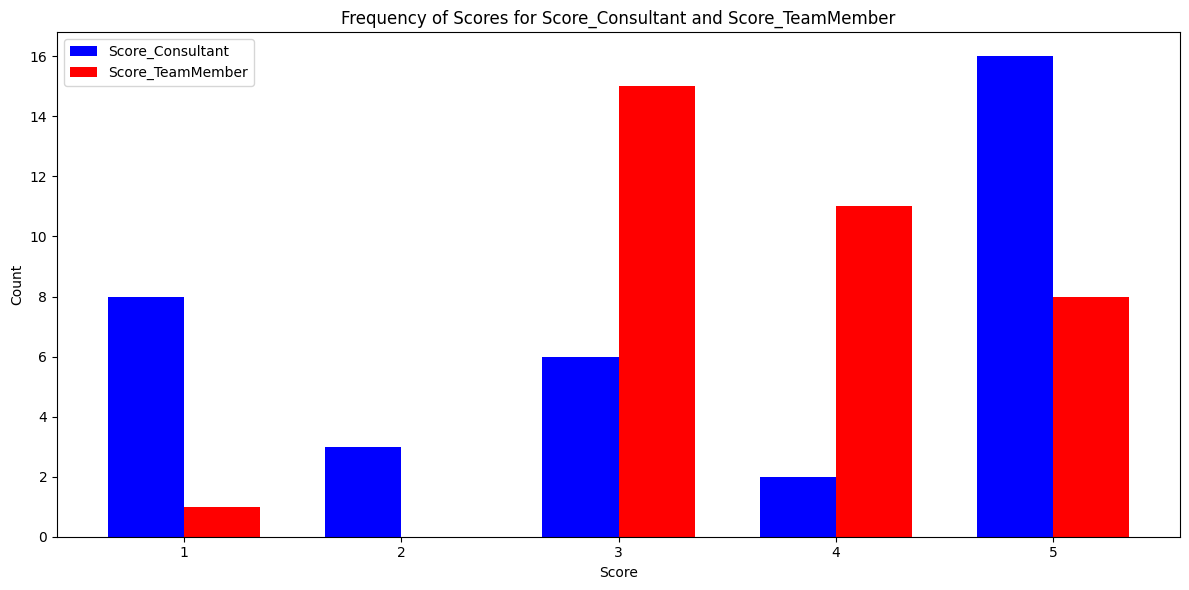

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the excel file
file_path = "/content/drive/Shareddrives/Capstone - deFacto Global/Model test/Result2.xlsx"
df = pd.read_excel(file_path)

# Remove non-numeric values
df = df[df['Score_Consultant'].apply(lambda x: isinstance(x, (int, float)))]
df = df[df['Score_TeamMember'].apply(lambda x: isinstance(x, (int, float)))]

# Calculate the frequency for each score
score_consultant_counts = df['Score_Consultant'].value_counts().sort_index()
score_teammember_counts = df['Score_TeamMember'].value_counts().sort_index()

# Ensure both series have the same indices
all_scores = sorted(set(score_consultant_counts.index) | set(score_teammember_counts.index))
score_consultant_counts = score_consultant_counts.reindex(all_scores, fill_value=0)
score_teammember_counts = score_teammember_counts.reindex(all_scores, fill_value=0)

# Set the position and width for the bars
bar_width = 0.35
index_consultant = np.arange(len(all_scores))
index_teammember = [i + bar_width for i in index_consultant]

# Create the bar charts side by side
plt.figure(figsize=(12,6))
plt.bar(index_consultant, score_consultant_counts.values, bar_width, label='Score_Consultant', color='blue')
plt.bar(index_teammember, score_teammember_counts.values, bar_width, label='Score_TeamMember', color='red')

# Set the labels, title, and legend for the chart
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Frequency of Scores for Score_Consultant and Score_TeamMember')
plt.xticks(index_consultant + bar_width/2, all_scores)  # Set the x-ticks to be in the middle of the two bars
plt.legend()

# Display the bar chart
plt.tight_layout()
plt.show()


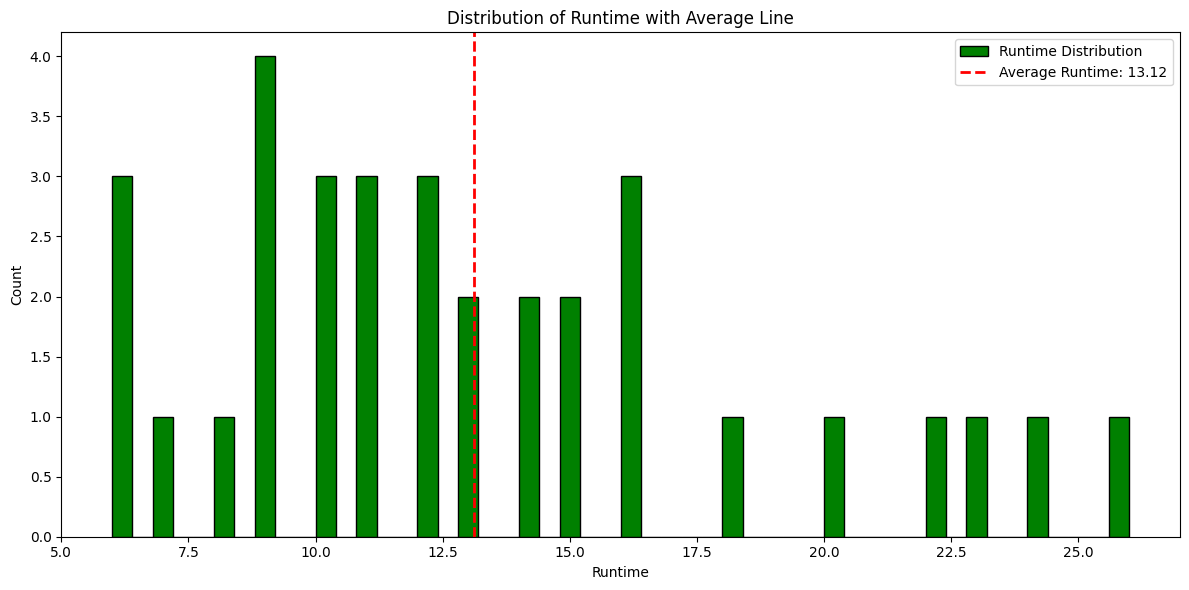

In [ ]:
# Remove non-numeric values from the 'runtime' column
df = df[df['runtime'].apply(lambda x: isinstance(x, (int, float)))]

# Calculate the average runtime
average_runtime = df['runtime'].mean()

# Create the histogram
plt.figure(figsize=(12,6))
plt.hist(df['runtime'], bins=50, color='green', edgecolor='black', label='Runtime Distribution')

# Add the average line
plt.axvline(average_runtime, color='red', linestyle='dashed', linewidth=2, label=f'Average Runtime: {average_runtime:.2f}')

# Set the labels and title for the chart
plt.xlabel('Runtime')
plt.ylabel('Count')
plt.title('Distribution of Runtime with Average Line')
plt.legend()

# Display the histogram
plt.tight_layout()
plt.show()